Global Fitting: Tutorial 1

In this tutorial, we will look at one of the simplest examples in of global fitting of the transient data. We will look at a molecule which will only decay via fluorescence after being excited.

$ E \xrightarrow[]{k_{fl}} GS + h \nu$

When in its ground state, the first traisition (HOMO - LUMO) is excited by 650 nm photons. The lowest energy transition for the excited molecule is at 400 nm. 

Lets begin by plotting the ideal absorption spectra of these two molecules. 

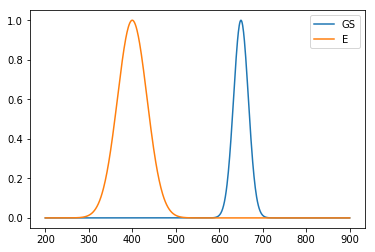

In [33]:
import numpy as np
import matplotlib.pyplot as plt

Wavelength_Range = np.linspace(200,900,701)

# The simple way to define a gaussian is: a*e^{-((x-b)/c)**2}. In the form below, I am expressing it in terms
# of the full-width half maximum instead of 'c'.

Gaussian = lambda x,center,fwhm,amplitude : amplitude * np.exp(-4*np.log(2)*(x-center)**2/(fwhm**2))

# I will give both spectrums an equal amplitude of 1, but I will make the excited spectrum a bit
# broader by increasing its fwhm.

Spectrum_GS = Gaussian(Wavelength_Range, 650,40,1)

Spectrum_E = Gaussian(Wavelength_Range, 400,80,1)

plt.plot(Wavelength_Range,Spectrum_GS,label='GS')
plt.plot(Wavelength_Range,Spectrum_E,label='E')
plt.legend()

In the transient experiment we are collecting a 'difference spectrum' at each delay time. This difference spectrum is generated by subtracting the 'unpumped' absorption spectrum from the 'pumped' absortion spectrum. 

In practice, the difference between the pumped and un-pumped absorption is small, because only a small percentage of the molecules become excited.

If the pump excites 10% of the molecules, then the raw pumped and un-pumped absorption spectra will look the following way:

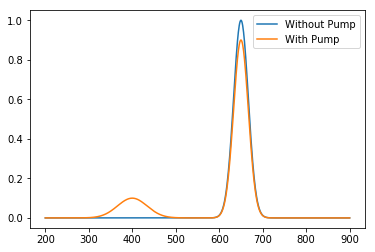

In [34]:
Spectrum_NoPump = Spectrum_GS
Spectrum_Pump = 0.9*Spectrum_GS + 0.1*Spectrum_E

plt.plot(Wavelength_Range,Spectrum_NoPump,label='Without Pump')
plt.plot(Wavelength_Range,Spectrum_Pump,label='With Pump')
plt.legend()

The difference spectrum is calculated as the difference between the spectra.

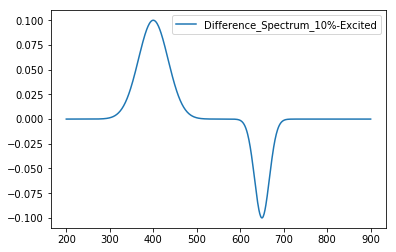

In [35]:
Difference_Spectrum = Spectrum_Pump-Spectrum_NoPump
plt.plot(Wavelength_Range,Difference_Spectrum,label='Difference_Spectrum_10%-Excited')
plt.legend()


If you look back at how the difference spectrum is calculated, you can check that it may be simplified to:

$\omega_{Diff} = C_{E} * (\omega_{E} - \omega_{GS} )$

The spectrum $SAS_E =(\omega_{E} - \omega_{GS} )$ is thus called the 'Species Associated Spectrum' (SAS) of the excited species 'E'.

Similarily, the SAS of the GS is $SAS_{GS} = (\omega_{GS} - \omega_{GS}) = 0$

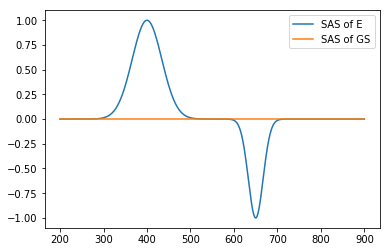

In [36]:
# Plot of the species assoiated spectra

SAS_E = Spectrum_E - Spectrum_GS
SAS_GS = Spectrum_GS - Spectrum_GS

plt.plot(Wavelength_Range,SAS_E,label='SAS of E')
plt.plot(Wavelength_Range,SAS_GS,label='SAS of GS')
plt.legend()

When we collect a spectrum, the total spectrum contains the species associated spectra of each of the species present in the solution at that particular time. The amount of contribution, or weight, of a specific SAS depends on the concentration of its associated species at that given time.

In this tutorial we will model the following: At $ t = t_0$, the excited state population of E is immediatelly created*. Any solvent relaxation, geometric rearrangement, or vibrational cooling is neglected. The only pathways for the decay of E is via fluorescence.  

$\frac{dC_{E}}{dt} = -k_{fl}C_{E}$


$C_{E}(t) = C_{E}(0) \ e^{-k_{fl}t} = C_{E}(0) \ e^{-t/\tau_{fl}}$


Where $\tau_{fl} = 1/k_{fl}$ is the fluorescence lifetime.

Since the SAS of E is the only non-zero spectrum present, our transient spectrum at any given time can be expressed as:

$Transient \ Spectrum = C_{E}(t) \times \ SAS_E$

*This is never true, because pulses have a finite width. Sometimes it is O.K. to make this approximation, but often it isn't... The rise of the population is part of what is modelled by the 'instrument response function' (IRF), but we won't discuss that in this tutorial.


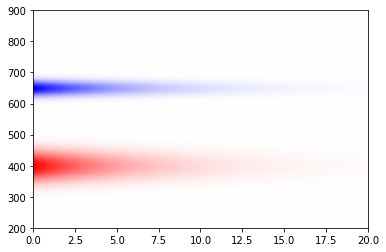

In [37]:
# Lets define the function CE(t)

CEt = lambda tau,CE0,t : CE0*np.exp(-t/tau)

# Lets define t to go from 0 to 20 ns...

t = np.linspace(0,20,100)

# Now lets let CE0 = 1, assign a fluorescence lifetime of 5 ns to our excited state, and create the CEt vector...

CEt_vector = CEt(5,1,t)

TS = np.outer(SAS_E,CEt_vector)

plt.pcolormesh(t,Wavelength_Range,TS,cmap='bwr')


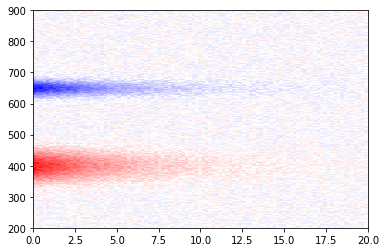

In [38]:
# Ral data is never so perfect.. So let's add some noise!
noise = (np.random.rand(*TS.shape)-0.5)/5
TS += noise
plt.pcolormesh(t,Wavelength_Range,TS,cmap='bwr')


When processing your data, this transient data matrix is yout starting point (after you load your data). Of course, in the real analysis, we do not know neither the spectra, the kinetic constants, nor the kinetic model a-priori! The goal is to obtain the species associated spectra and kinetics by fitting a reasonable model to the data. We will now work backwards and obtain the model from this data.

Text(0.5, 1.0, '400.0 nm')

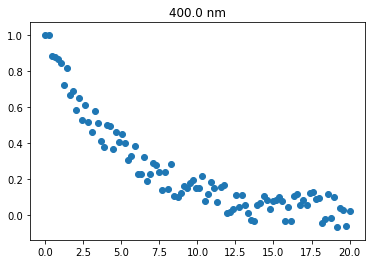

In [39]:
# Let's now plot the noisy decay trace of the excited state absorption band at 400 nm
plt.scatter(t,TS[200,:])
plt.title("%s nm" % Wavelength_Range[200])

We will now fit the signal decay at 400 nm to a mono exponential:

The fluorescence lifetime is 5.10 +/- 0.16 ns


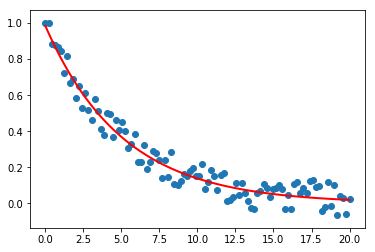

In [40]:
from scipy.optimize import curve_fit

def mono_exponential_model(t,a,tau):
    return a*np.exp(-t/tau)

# Alternative form: 
# mono_exponential_model = lambda t,A,tau: A*np.exp(-t/tau)

popt,pcov = curve_fit(mono_exponential_model,t,TS[200,:])
plt.scatter(t,TS[200,:])
plt.plot(t,mono_exponential_model(t,*popt),c='r',lw=2)
print("The fluorescence lifetime is %0.2f +/- %0.2f ns" % (popt[1],np.sqrt(pcov[1,1])))

We can see that our real value of 5 ns falls within the range of the fitted value with its error! That's good.

What happens if we now fit multiple lines independently?

The fluorescence lifetime at 350 nm is 5.28 +/- 0.49 ns
The fluorescence lifetime at 375 nm is 4.72 +/- 0.20 ns
The fluorescence lifetime at 400 nm is 5.10 +/- 0.16 ns
The fluorescence lifetime at 425 nm is 4.63 +/- 0.20 ns
The fluorescence lifetime at 450 nm is 5.55 +/- 0.54 ns


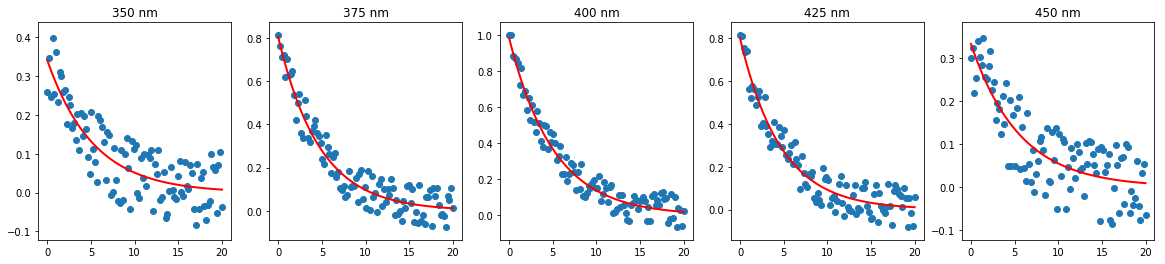

In [41]:
Selection = [150,175,200,225,250] # The slection of indexes for performing the fit.
fig = plt.figure()
fig.set_figwidth(20)
for i in range(0,5):
    wL = int(Wavelength_Range[Selection[i]])
    plt.subplot(1,5,i+1)
    popt,pcov = curve_fit(mono_exponential_model,t,TS[Selection[i],:])
    plt.scatter(t,TS[Selection[i],:])
    plt.plot(t,mono_exponential_model(t,*popt),c='r',lw=2)
    plt.title("%s nm" % wL)
    print("The fluorescence lifetime at %s nm is %0.2f +/- %0.2f ns" % (wL, popt[1],np.sqrt(pcov[1,1])))

We can see that every line has a slightly different predicted time constant. We know that this shoudl not be the case! The whole signal depends on the decay of a single species, and so they should all decay the same way. The process of fitting all of these curves simultaneously is known as "global fitting".

First lets perform a gloabal fit using the not-so-elegant brute force approach. What we want to do is to fit all of these curves, each using a different 'A' but sharing the tau. I am not sure yet how to explain it with words, so I'll just do it.

The first step is to stitch these five d

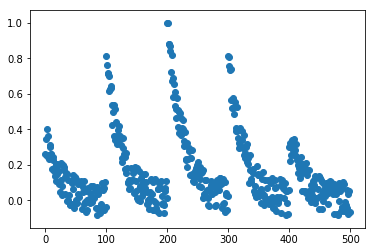

In [42]:
Stitched_Data = []
for i in Selection:
    Stitched_Data.append(TS[i,:])


Stitched_Data = np.asarray(Stitched_Data).flatten()
x = range(len(Stitched_Data)) # We don't want to use t as the x axis at this point! 
plt.scatter(x,Stitched_Data)

Maybe you now see where this is going.... We now have all of the points that we want to fit in the same array, and so all we need to do now is to generate a guess array with the same format! Again, I'll just show you how it is done and hopefully it makes sense. Otherwise let me know and I'll see how I can explain it better. 

In [43]:
def global_model(t,a1,a2,a3,a4,a5,tau):
    A = [a1,a2,a3,a4,a5]
    guess = []
    for a in A:
        guess.append(a*np.exp(-t/tau))
    return np.asarray(guess).flatten()

This new model will loop over each of the a's using the same tau, and then it will output a guess array that has the same format as the stitched data! Lets now perform the fit!

The globally fitted fluorescence lifetime is 4.91 +/- 0.10 ns


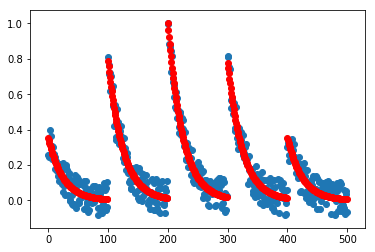

In [44]:
popt,pcov = curve_fit(global_model,t,Stitched_Data) # Perform the global fit
plt.scatter(x,Stitched_Data)
plt.scatter(x,global_model(t,*popt),color='r')
print("The globally fitted fluorescence lifetime is %0.2f +/- %0.2f ns" % (popt[5],np.sqrt(pcov[5,5])))

Now you are certainly wondering: But Max! Why didn't we just pass 'A' directly as a vector in the global_model instead of passing a1,a2,a3,a4,a5?! If we want to fit the 701 wavelengths simultaneously we will need to create a very long list....

The reason is simple: curve_fit does allow you to fit a vector. You can try it out, but it will fail. Let us now use least_squares instead. The least squares works almost the same way, except that the 'model function' should return the residuals.


The globally fitted fluorescence lifetime is 4.91 +/- 0.10 ns


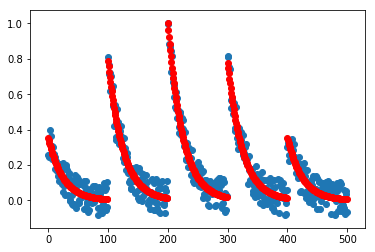

In [45]:
from scipy.optimize import least_squares

def global_model(G,t,measured_data): #NOTE: Now the parameters to be fitted (G) are the first parameters for the function, unlike for curve_fit!
    A = G[0:-1]
    tau = G[-1]
    guess = []
    for a in A:
        guess.append(a*np.exp(-t/tau))
    return (np.asarray(guess).flatten() - measured_data) # Must return the resudials (guess - measurement)

G0 = np.ones(6) # For this method you MUST provide an initial guess array!
res_lsq = least_squares(global_model,G0,args=(t,Stitched_Data))

plt.scatter(x,Stitched_Data)
plt.scatter(x,global_model(res_lsq.x,t,Stitched_Data)+Stitched_Data,color='r')


# The errors are  a bit trickier to calculate, because this method won't do it automatically for us...
# But don't worry too much about this part for now.

_, s, VT = np.linalg.svd(res_lsq.jac,full_matrices=False)
threshold = np.finfo(float).eps * max(res_lsq.jac.shape)*s[0]
s = s[s>threshold]
VT = VT[:s.size]
pcov = np.dot(VT.T / s**2, VT)
s_sq = (global_model(res_lsq.x,t,Stitched_Data)**2).sum()/(len(Stitched_Data.flatten())-len(G0))
pcov = pcov * s_sq
err = np.sqrt(np.diag(pcov))
print("The globally fitted fluorescence lifetime is %0.2f +/- %0.2f ns" % (res_lsq.x[5],err[5]))

As you can see, using the least_squares method we get exactly the same result. As we should, because we are basically doing the same thing that curve_fit does. 

Doing this might seem like extra work, but it gives us a new super power: we are now able to fit vectors! For this 'silly fitting' it saves us the work of having to explicity type 700 a's, but this property will become essential when we move into the more advanced fitting methods using linear algebra. 

For now, I will take this silly fitting method to its extreme and perform the whole global fit.


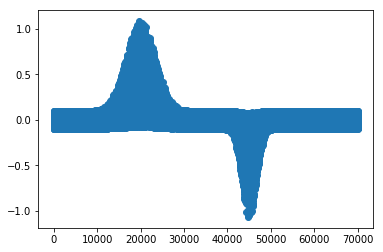

In [46]:
y = TS.flatten()
x = range(len(y))
plt.scatter(x,y)

It might not be so easy to see at first, but the plot above really is all of the stitched decays. You can 'zoom in' into a region in order to see the detail:

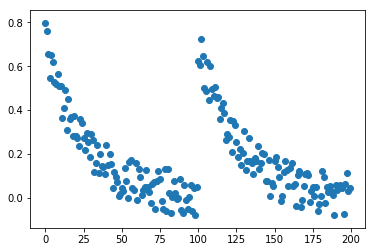

In [47]:
plt.scatter(range(len(y[22800:23000])),y[22800:23000])

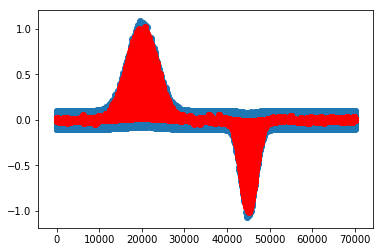

In [48]:
G0 = np.ones(len(Wavelength_Range)+1)
res_lsq = least_squares(global_model,G0,args=(t,y))
plt.scatter(x,y)
plt.scatter(x,global_model(res_lsq.x,t,y)+y,color='r')

# This might take a while...

We may now extract the fitted spectrum and the decay!


The globally fitted decay lifetime is 5.02 +/- 0.02 ns


Text(0.5, 1.0, 'Fitted Spectrum')

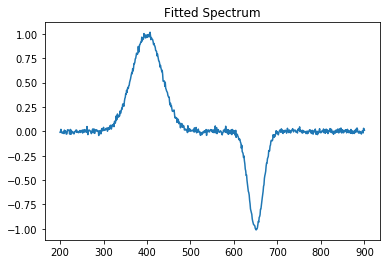

In [49]:
Spectrum = res_lsq.x[0:-1]
tau = res_lsq.x[-1]


##### Error calculation
_, s, VT = np.linalg.svd(res_lsq.jac,full_matrices=False)
threshold = np.finfo(float).eps * max(res_lsq.jac.shape)*s[0]
s = s[s>threshold]
VT = VT[:s.size]
pcov = np.dot(VT.T / s**2, VT)
s_sq = (global_model(res_lsq.x,t,y)**2).sum()/(len(y.flatten())-len(G0))
pcov = pcov * s_sq
err = np.sqrt(np.diag(pcov))
##### END error calculation

print("The globally fitted decay lifetime is %0.2f +/- %0.2f ns" % (res_lsq.x[-1],err[-1]))
Spectrum_Error = err[0:-1]
plt.plot(Wavelength_Range,Spectrum)
#plt.fill_between(Wavelength_Range,Spectrum+Spectrum_Error,Spectrum-Spectrum_Error,color='r') # Spectrum error in red
plt.title('Fitted Spectrum')

As you can see, with the global fit we have now obtained an excellent fit to the spectrum with a very small error! 

In tutorial 2 I will discuss matrices in much greater depth, but below you can see how to perform this fit using matrix operations instead of a for-loop. Essentially, if you look back at input 6, we generated the transient matrix by performing the outer product between the spectrum and the concentration over time. In most cases we will be working with more dimensions, so we will be using 'np.dot()' instead. We need to now create our model in this form. In most cases, we will use the dot-product instead of the outer product function.


In [31]:
def matrix_model(G,t,measured_data):
    Spectrum = G[0:-1]
    tau = G[-1]
    CE = np.exp(-t/tau)
    guess = np.outer(Spectrum,CE)
    return (guess-measured_data).flatten() # We can work with matrices within the model, but the residuals must always be returned as an array

G0 = np.ones(len(Wavelength_Range)+1)
res_lsq = least_squares(global_model,G0,args=(t,y))

